In [112]:
using CSV, DataFrames, JuMP, Gurobi, StatsPlots, Random, Statistics, Plots

# Read in data

In [2]:
# Availability
availability = CSV.read("../data/availability.csv", DataFrame)
col_order = [1, 9, 8, 7, 6, 5, 4, 3, 2]
availability = availability[:, col_order]
availability = sort(availability, :Region)

Row,Region,yr_2016_shoes,yr_2017_shoes,yr_2018_shoes,yr_2019_shoes,yr_2020_shoes,yr_2021_shoes,yr_2022_shoes,yr_2023_shoes
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AMERICAS,5.01118e6,5.27466e6,5.55227e6,5.84445e6,6.15248e6,6.47593e6,6.81695e6,7.17597e6
2,EMEA,7.5187e5,7.91713e5,8.33269e5,8.76967e5,9.23236e5,9.71647e5,1.02306e6,1.07704e6
3,N ASIA,2.10918e7,2.22018e7,2.33705e7,2.46005e7,2.58952e7,2.72584e7,2.86932e7,3.02033e7
4,S ASIA,7.66629e7,8.06977e7,8.4945e7,8.9416e7,9.41221e7,9.90759e7,1.0429e8,1.09779e8
5,SE ASIA,9.51028e7,1.00108e8,1.05377e8,1.10923e8,1.16761e8,1.22907e8,1.29376e8,1.36185e8


In [3]:
# Demand
demand = CSV.read("../data/demand.csv", DataFrame)
replace!(demand.Region, "Europe, Middle East, and Africa" => "EMEA")
demand

Row,Region,2016,2017,2018,2019,2020,2021,2022,2023
,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Asia Pacific,1.84351e7,2.06687e7,2.24933e7,2.27891e7,2.17006e7,2.30219e7,2.58658e7,2.85839e7
2,EMEA,4.32876e7,4.45665e7,5.04292e7,5.40172e7,5.05751e7,5.98283e7,6.34163e7,7.09013e7
3,Greater China,2.2309e7,2.50644e7,3.00086e7,3.65837e7,3.97854e7,4.93391e7,4.64893e7,4.66524e7
4,Latin America,6.71511e6,7.52871e6,8.19335e6,8.30106e6,7.90458e6,8.38586e6,9.42178e6,1.04119e7
5,North America,7.98197e7,8.31245e7,8.00172e7,8.62232e7,8.00773e7,9.99485e7,1.04961e8,1.27871e8


In [4]:
# Revenue
revenue = CSV.read("../data/rev.csv", DataFrame)
replace!(revenue.Region, "Europe, Middle East, and Africa" => "EMEA")
rev_year = []
for i in 2:size(revenue)[2]
    col_sum = sum(revenue[:, i]) * 1e6
    append!(rev_year, col_sum)
end
rev_year = Array(rev_year);
revenue

Row,Region,2016,2017,2018,2019,2020,2021,2022,2023
,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Asia Pacific,2147.69,2407.9,2620.47,2654.93,2528.12,2682.05,3013.36,3330.02
2,EMEA,5043.0,5192.0,5875.0,6293.0,5892.0,6970.0,7388.0,8260.0
3,Greater China,2599.0,2920.0,3496.0,4262.0,4635.0,5748.0,5416.0,5435.0
4,Latin America,782.31,877.095,954.525,967.074,920.883,976.953,1097.64,1212.98
5,North America,9299.0,9684.0,9322.0,10045.0,9329.0,11644.0,12228.0,14897.0


In [5]:
# Holding costs
holding_costs = CSV.read("../data/inventory_holding_cost.csv", DataFrame)[:, 2:end]

Row,Year,holding_cost_per_shoe
,Int64,Float64
1,2016,42.76
2,2017,49.47
3,2018,37.26
4,2019,43.52
5,2020,39.9
6,2021,33.37
7,2022,34.53
8,2023,43.01


In [6]:
# Shipping (transport costs)
shipping_costs = CSV.read("../data/transport_costs.csv", DataFrame)

Row,producer_region,consumer_region,distance,shipping_cost_2014,shipping_cost_2015,shipping_cost_2016,shipping_cost_2017,shipping_cost_2018,shipping_cost_2019,shipping_cost_2020,shipping_cost_2021,shipping_cost_2022,shipping_cost_2023
,String15,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,SE ASIA,Asia Pacific,0.331077,0.264157,0.203646,0.183564,0.19933,0.188843,0.176486,0.261308,1.08032,0.906917,0.189632
2,S ASIA,Asia Pacific,0.411961,0.328692,0.253398,0.22841,0.248028,0.234978,0.219602,0.325147,1.34425,1.12848,0.235961
3,N ASIA,Asia Pacific,0.261674,0.208782,0.160956,0.145084,0.157545,0.149256,0.139489,0.206531,0.853856,0.716802,0.14988
4,EMEA,Asia Pacific,0.831463,0.6634,0.511433,0.461,0.500596,0.474257,0.443224,0.656245,2.7131,2.27762,0.47624
5,AMERICAS,Asia Pacific,1.48839,1.18754,0.91551,0.82523,0.89611,0.848961,0.793409,1.17474,4.85669,4.07714,0.852511
6,SE ASIA,Greater China,0.209922,0.167491,0.129123,0.11639,0.126387,0.119737,0.111902,0.165684,0.684986,0.575038,0.120238
7,S ASIA,Greater China,0.358238,0.285828,0.220353,0.198623,0.215683,0.204335,0.190964,0.282745,1.16895,0.98132,0.20519
8,N ASIA,Greater China,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,EMEA,Greater China,0.590866,0.471435,0.363442,0.327603,0.355741,0.337023,0.31497,0.46635,1.92803,1.61856,0.338433


In [7]:
shipping_mapping = shipping_costs[:, 1:2]
shipping_mapping = sort(shipping_mapping, [:producer_region, :consumer_region], rev=[false, false])
shipping_mapping = hcat(DataFrame(Row_Count=1:nrow(shipping_mapping)), shipping_mapping)
shipping_mapping = combine(groupby(shipping_mapping, [:producer_region, :consumer_region])) do sub_df
    DataFrame(Value_mean = first(sub_df.Row_Count))
end
shipping_mapping = unstack(shipping_mapping, :consumer_region, :Value_mean)
shipping_mapping = sort(shipping_mapping, :producer_region)

Row,producer_region,Asia Pacific,Greater China,EMEA,North America,Latin America
,String15,Int64?,Int64?,Int64?,Int64?,Int64?
1,AMERICAS,1,3,2,5,4
2,EMEA,6,8,7,10,9
3,N ASIA,11,13,12,15,14
4,S ASIA,16,18,17,20,19
5,SE ASIA,21,23,22,25,24


In [8]:
# Production costs
production_costs = CSV.read("../data/cost.csv", DataFrame)
replace!(production_costs.Region, "Europe, Middle East, and Africa" => "EMEA");
col_order = [1, 9, 8, 7, 6, 5, 4, 3, 2]
production_costs = production_costs[:, col_order]

Row,Region,yr_2016_shoes,yr_2017_shoes,yr_2018_shoes,yr_2019_shoes,yr_2020_shoes,yr_2021_shoes,yr_2022_shoes,yr_2023_shoes
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AMERICAS,42.4736,46.8013,42.2206,45.3675,41.4347,45.7763,42.6593,53.6259
2,EMEA,42.8708,42.2413,39.3912,43.1394,42.7613,46.795,43.5146,51.5969
3,N ASIA,41.9221,44.7956,45.5397,44.6927,41.2893,48.4448,41.7661,48.7874
4,S ASIA,40.5973,39.8473,43.839,41.9903,39.0235,46.958,42.9565,53.8705
5,SE ASIA,41.1064,46.5148,45.8819,43.0424,39.6504,47.5189,44.3342,51.1256


In [9]:
# Price of shoes
cost_of_shoes_init = 116.5
shoes_price_time = [116.5]
for i in 2:8
    shoes_price_minus_1 = shoes_price_time[i-1]
    shoe_price_current = shoes_price_minus_1 * 1.02
    append!(shoes_price_time, shoe_price_current)
end
shoes_price_time

8-element Vector{Float64}:
 116.5
 118.83
 121.2066
 123.630732
 126.10334664
 128.6254135728
 131.197921844256
 133.82188028114112

In [10]:
# Define sizes
num_suppliers = size(availability)[1] #i
num_consumer_regions = size(demand)[1] # j = c(i) 
num_time = size(availability)[2] - 1;  
num_producer_regions = size(availability)[1] # p(i)

5

# Set-up simple model

In [11]:
# Sets
suppliers = 1:num_suppliers
consumer_regions = 1:num_consumer_regions
producer_regions = 1:num_producer_regions
years = 1:num_time
years_incl_zero = 0:num_time

0:8

In [12]:
# Parameters and input data
A = Matrix(availability[:, 2:end]) #5x8
D = Matrix(demand[:, 2:end]) #5x8
R = Array(rev_year) #8x1
H = Array(holding_costs[:, 2]) #8x1
T = Matrix(shipping_costs[:, 6:end]) #25x8
W = Matrix(shipping_mapping[:, 2:end]) #encodes the prodcuer/consumer region for T 5x5
# W = convert(Matrix{Int}, W)
C = Matrix(production_costs[:, 2:end]); #5x8

## Creating the model

### Helper functions

In [13]:
# Set random seed
random_seed = 123
Random.seed!(random_seed);

In [14]:
# Helper functions
# Can be delta
function get_reductions(delta)
    reductions = []
    for i in 1:8
        reduction = maximum(rand(10)*delta)
        append!(reductions, reduction)
    end
    return reductions
end

delta = 0
reductions = get_reductions(delta)

8-element Vector{Any}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### Main functions

In [90]:
# Main function
function run_model(alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, integer, time, X_values_pre=nothing, E_values_pre=nothing)
    # Get uncertainty / reduction set
    # If delta = 0, reductions = 0 so there is no effect
    reductions = get_reductions(delta)

    # Get correct range of years by time period
    if time == "covid"
        years = 1:3
        years_to_filter = 6:8
        years_incl_zero = 0:3
        addl = 5
    elseif time == "all"
        years = 1:8
        years_to_filter = 1:8
        years_incl_zero = 0:8
        addl = 0
    end

    # Filter variables by years
    A = A[:, years_to_filter]
    D = D[:, years_to_filter]
    R = R[years_to_filter]
    H = H[years_to_filter]
    T = T[:, years_to_filter]
    C = C[:, years_to_filter]

    # Initialize model
    model = Model(Gurobi.Optimizer);

    # Set Gurobi solver parameter to suppress output
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Decision variables
    # X_{i,t} = quantity of shoes produced by supplier i (in producer region p(i)) at time t
    # S_{i,j,t} = quantity of shoes sold to consumer region j at time t, that are produced by supplier i (in producer region p(i))
    # E_{i,t} = holding quantity of shoes by supplier i (in producer region p(i)) at time t
    # M_{i,t} = marginal cost of getting supplier i to produce shoes at time t
    if integer == true
        @variable(model, X[suppliers, years_incl_zero] >= 0, Int);
        @variable(model, S[suppliers, consumer_regions, years] >= 0, Int);
        @variable(model, E[suppliers, years_incl_zero] >= 0, Int);
        @variable(model, M[consumer_regions, years] >= 0, Int);
    else
        @variable(model, X[suppliers, years_incl_zero] >= 0);
        @variable(model, S[suppliers, consumer_regions, years] >= 0);
        @variable(model, E[suppliers, years_incl_zero] >= 0);
        @variable(model, M[consumer_regions, years] >= 0);
    end
    
    # Objective function
    @objective(model, Max, 
    sum(sum(sum((shoes_price_time[t]-T[W[i,j],t]) * S[i,j,t] for i in suppliers) for j in consumer_regions) for t in years) 
    - sum(sum(C[i,t] * X[i,t] + H[t] * E[i,t] + alpha * shoes_price_time[t] * M[i,t] for i in suppliers) for t in years))

    # Constraints
    if time != "covid"
        @constraint(model, initial_production_constraint[i in suppliers], X[i,0] == 0);
        @constraint(model, initial_excess_constraint[i in suppliers], E[i,0] == 0);
    else
        @constraint(model, initial_production_constraint[i in suppliers], X[i,0] == X_values_pre[i,5]);
        @constraint(model, initial_excess_constraint[i in suppliers], E[i,0] == E_values_pre[i,5]);
    end

    @constraint(model, production_sold_excess_relationship[i in suppliers, t in years], sum(S[i,j,t] for j in consumer_regions) == X[i,t] + E[i,t-1] - E[i,t]);
    # @constraint(model, time_in_inventory[i in suppliers, t in years], sum(S[i,j,t] for j in consumer_regions) >= E[i,t-1]); #goods can't be in inventory more than 1 year
    @constraint(model, demand_constraint[j in consumer_regions, t in years], sum(S[i,j,t] for i in suppliers) <= D[j,t]);
    @constraint(model, unmet_demand[j in consumer_regions, t in years], M[j,t] == D[j,t] - sum(S[i,j,t] for i in suppliers)); # M[i,t] = max{X[i,t] − X[i,t−1], 0}
    @constraint(model, supply_production_constraint[i in suppliers, t in years], X[i,t] <= A[i,t] * (1 - reductions[t])); # add uncertainty

    # Optimize model
    optimize!(model);

    # Get values
    X_values = Matrix(value.(X))
    S_values = value.(S)
    E_values = Matrix(value.(E))
    M_values = Matrix(value.(M))

    return model, X_values, S_values, E_values, M_values
end

run_model (generic function with 3 methods)

In [143]:
function get_statistics(model, X, S, E, M, time, alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print)
    # Get correct range of years by time period
    if time == "all"
        years = 1:8
        years_to_filter = 1:8
        years_to_filter_variables = 1:8
        years_to_filter_variables_with_zero = 2:9
        addl = 0
    elseif time == "pre_covid"
        years = 1:5
        years_to_filter = 1:5
        years_to_filter_variables = 1:5
        years_to_filter_variables_with_zero = 2:6
        addl = 0
    # Getting stats for Covid years but optimized across all years
    elseif time == "covid_opt_for_all_years"
        years = 1:3
        years_to_filter = 6:8
        years_to_filter_variables = 6:8
        years_to_filter_variables_with_zero = 7:9
        addl = 5
    # Getting stats for Covid years and optimized only for Covid years
    elseif time == "covid_opt_for_covid_years"
        years = 1:3
        years_to_filter = 6:8
        years_to_filter_variables = 1:3
        years_to_filter_variables_with_zero = 2:4
        addl = 0
    end

    # Filter variables by years
    A = A[:, years_to_filter]
    D = D[:, years_to_filter]
    R = R[years_to_filter]
    H = H[years_to_filter]
    T = T[:, years_to_filter]
    C = C[:, years_to_filter]
    X = X[:, years_to_filter_variables_with_zero]
    S = S[:, :, years_to_filter_variables]
    E = E[:, years_to_filter_variables_with_zero]
    M = M[:, years_to_filter_variables]
    shoes_price_time = shoes_price_time[years_to_filter]
    
    net_profit_model = round(objective_value(model), digits=1)
    shipping_cost = round(sum(sum(sum((T[W[i,j],t]) * S[i,j,t+addl] for i in suppliers) for j in consumer_regions) for t in years), digits=1)
    sales = round(sum(sum(sum((shoes_price_time[t]) * S[i,j,t+addl] for i in suppliers) for j in consumer_regions) for t in years), digits=1)
    production_cost = round(sum(sum((C[i,t]) * X[i,t] for i in suppliers) for t in years), digits=1)
    holding_cost = round(sum(sum(H[t] * E[i,t] for i in suppliers) for t in years), digits=1)
    penalty_unmet_demand = round(sum(sum(alpha * shoes_price_time[t] * M[i,t] for i in suppliers) for t in years), digits=1)
    # We exclude unmet demand because that is not a real cost
    net_profit = sales - shipping_cost - production_cost - holding_cost

    if print == true
        println("\n --- Statistics (", time, ") ---")
        println("Net profit (from model): ", net_profit_model)
        println("Shipping cost: ", shipping_cost)
        println("Sales: ", sales)
        println("Production cost: ", production_cost)
        println("Holding cost: ", holding_cost)
        println("Penalty unmet demand: ", penalty_unmet_demand)
        println("Net profit (for specific years): ", net_profit)
    end
    
    return net_profit
end

get_statistics (generic function with 2 methods)

## Collect key statistics of interest for 1 combination of parameters by running model multiple times and processing output

In [144]:
function get_key_stats_for_a_combi_of_params(alpha, delta, epsilon, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print=false)
    # First plan with availability from 2016-2023, 
    # with some penalty for unmet demand (alpha) and accounting for some variability.
    # Here, delta = delta = business uncertainty 
    # Get statistics from 2016-2020. These are fixed.
    model_pre_covid, X_values_pre_covid, S_values_pre_covid, E_values_pre_covid, M_values_pre_covid = run_model(alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, true, "all");
    net_profit_all = get_statistics(model_pre_covid, X_values_pre_covid, S_values_pre_covid, E_values_pre_covid, M_values_pre_covid, "all", alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print);
    net_profit_pre_covid = get_statistics(model_pre_covid, X_values_pre_covid, S_values_pre_covid, E_values_pre_covid, M_values_pre_covid, "pre_covid", alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print);
    net_profit_covid_opt_for_all_years = get_statistics(model_pre_covid, X_values_pre_covid, S_values_pre_covid, E_values_pre_covid, M_values_pre_covid, "covid_opt_for_all_years", alpha, delta, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print);

    # Then introduce exogenous availability shock from 2021-2023,
    # with the same penalty for unmet demand (alpha) but now without accounting for any variability.
    # Here, delta = epsilon = exogenous shock
    model_covid, X_values_covid, S_values_covid, E_values_covid, M_values_covid = run_model(alpha, epsilon, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, true, "covid", X_values_pre_covid, E_values_pre_covid);
    net_profit_covid_opt_for_covid_years = get_statistics(model_covid, X_values_covid, S_values_covid, E_values_covid, M_values_covid, "covid_opt_for_covid_years", alpha, epsilon, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, print);

    # Get key statistics
    profit = net_profit_pre_covid + net_profit_covid_opt_for_covid_years
    inventory_2020 = sum(E_values_pre_covid[:,6])
    herfindahl_2020 = sum((X_values_pre_covid[:,6] / sum(X_values_pre_covid[:,6])).^2)

    println("\n--- Parameters: alpha=", alpha, ", delta=", delta, ", epsilon=", epsilon, " ---")
    println("Profit: ", profit)
    println("Inventory in 2020: ", inventory_2020)
    println("Herfindahl in 2020 (supplier diversification index): ", herfindahl_2020)

    return profit, inventory_2020, herfindahl_2020
end

get_key_stats_for_a_combi_of_params (generic function with 2 methods)

In [145]:
# Test it out
alpha = 0.1 # penalty on unmet demand
delta = 0 # business uncertainty
epsilon = 0 # exogenous shock
profit, inventory_2020, herfindahl_2020 = get_key_stats_for_a_combi_of_params(alpha, delta, epsilon, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C, true);


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22

 --- Statistics (all) ---
Net profit (from model): 1.381185064242e11
Shipping cost: 2.0212190121e9
Sales: 2.172908081443e11
Production cost: 7.71510826044e10
Holding cost: 103.6
Penalty unmet demand: 0.0
Net profit (for specific years): 1.3811850642419998e11

 --- Statistics (pre_covid) ---
Net profit (from model): 1.381185064242e11
Shipping cost: 5.45514723e8
Sales: 1.15471908771e11
Production cost: 4.01128780571e10
Holding cost: -0.0
Penalty unmet demand: 0.0
Net profit (for specific years): 7.48135159909e10

 --- Statistics (covid_opt_for_all_years) ---
Net profit (from model): 1.381185064242e11
Shipping cost: 1.4757042892e9
Sales: 1.018188993733e11
Production cost: 3.70382045473e10
Holding cost: 103.6
Penalty unmet demand: 0.0
Net profit (for specific years): 6.3304990433200005e10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22

 --- Statistics (cov

## Collect key statistics of interest for all combinations of parameters using a loop

### Define sets of parameters

In [164]:
# Penalty on unmet demand
alpha_range = [0, 0.1, 0.25, 0.5, 0.75, 1];

# Degree of robustness prepared for (by business)
delta_range = [0, 0.01, 0.025, 0.05, 0.1, 0.2];

# Severity of availability shock (exogenous, from Covid-19)
epsilon_range = [0, 0.1, 0.25, 0.5];

In [165]:
# Run get_key_stats_for_a_combi_of_params on all combinations of alpha, delta, epsilon
alpha_values = []
delta_values = []
epsilon_values = []
profit_values = []
inventory_2020_values = []
herfindahl_2020_values = []
for alpha in alpha_range
    for delta in delta_range
        for epsilon in epsilon_range
            profit, inventory_2020, herfindahl_2020 = get_key_stats_for_a_combi_of_params(alpha, delta, epsilon, suppliers, consumer_regions, producer_regions, shoes_price_time, A, D, R, H, T, W, C);
            append!(alpha_values, alpha)
            append!(delta_values, delta)
            append!(epsilon_values, epsilon)
            append!(profit_values, profit)
            append!(inventory_2020_values, inventory_2020)
            append!(herfindahl_2020_values, herfindahl_2020)
        end
    end
end

# Create dataframe
df = DataFrame(alpha=alpha_values, delta=delta_values, epsilon=epsilon_values, profit=profit_values, inventory_2020=inventory_2020_values, herfindahl_2020=herfindahl_2020_values)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22

--- Parameters: alpha=0.0, delta=0.0, epsilon=0.0 ---
Profit: 1.381185064241e11
Inventory in 2020: -0.0
Herfindahl in 2020 (supplier diversification index): 0.5017393664001494
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22

--- Parameters: alpha=0.0, delta=0.0, epsilon=0.1 ---
Profit: 1.350898311492e11
Inventory in 2020: -0.0
Herfindahl in 2020 (supplier diversification index): 0.5017393664001494
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22

--- Parameters: alpha=0.0, delta=0.0, epsilon=0.25 ---
Profit: 1.26120055063e11
Inventory in 2020: 

Row,alpha,delta,epsilon,profit,inventory_2020,herfindahl_2020
,Any,Any,Any,Any,Any,Any
1,0.0,0.0,0.0,1.38119e11,-0.0,0.501739
2,0.0,0.0,0.1,1.3509e11,-0.0,0.501739
3,0.0,0.0,0.25,1.2612e11,-0.0,0.501739
4,0.0,0.0,0.5,1.10687e11,-0.0,0.501739
5,0.0,0.01,0.0,1.38107e11,-0.0,0.502276
6,0.0,0.01,0.1,1.34844e11,-0.0,0.502317
7,0.0,0.01,0.25,1.2551e11,-0.0,0.502296
8,0.0,0.01,0.5,1.10538e11,-0.0,0.502277
9,0.0,0.025,0.0,1.38085e11,-0.0,0.503284


# Plot results

In [167]:
# Plot a graph of profit vs alpha for varying epsilons in a graph where delta=0.1
df_plot = filter(row -> row.epsilon == 0.5, df)
df_plot




Row,alpha,delta,epsilon,profit,inventory_2020,herfindahl_2020
,Any,Any,Any,Any,Any,Any
1,0.0,0.0,0.5,1.10687e11,-0.0,0.501739
2,0.0,0.01,0.5,1.10538e11,-0.0,0.502277
3,0.0,0.025,0.5,1.0971e11,-0.0,0.503326
4,0.0,0.05,0.5,1.109e11,-0.0,0.505532
5,0.0,0.1,0.5,1.10717e11,1.1531e7,0.41984
6,0.0,0.2,0.5,1.06731e11,865832.0,0.39017
7,0.1,0.0,0.5,1.10343e11,-0.0,0.501739
8,0.1,0.01,0.5,1.08942e11,-0.0,0.502281
9,0.1,0.025,0.5,1.11115e11,-0.0,0.503083


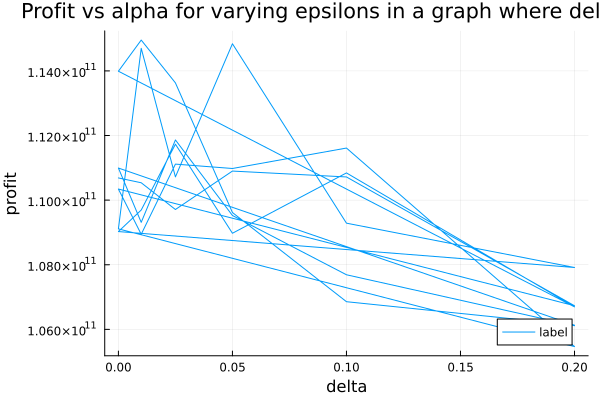

In [168]:
# df_plot = sort(df_plot, :delta)
plot(df_plot.delta, df_plot.profit, group=df_plot.epsilon, label="label", xlabel="delta", ylabel="profit", title="Profit vs alpha for varying epsilons in a graph where delta=0.1", legend=:bottomright)


### 2.b. Covid-19 hits with reduction in demand of delta (a new parameter). 
- Implementation-wise, this is the same as the delta parameter.
- However, in terms of interpretation, delta in 2a is something enforced artificially by the producer, while delta in 2b is something enforced by actual constraints.
- We assume that during Covid-19, businesses do not try to plan with uncertainty and are solely focused on meeting demand.

In [ ]:
# Plot graphs

# Total costs over t
# Region

# Holding quantity over t

# Herfindalhs over t
# Plot graphs across alphas
# Ave Holding quantity over t
# Ave Herfindalhs over t
